In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv


In [2]:
df1 = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')
df2 = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')

In [3]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [4]:
df1 = df1[['clean_text', 'category']]
df1.columns = ['text', 'label']
df1.dropna(inplace=True)

In [5]:
df2 = df2[['clean_comment', 'category']]
df2.columns = ['text', 'label']
df2.dropna(inplace=True)

In [6]:
df = pd.concat([df1, df2]).reset_index(drop=True)

In [7]:
df = df[df['text'].str.strip() != '']

In [8]:
df = df.groupby('label').apply(lambda x: x.sample(30000, random_state=42)).reset_index(drop=True)

<ipython-input-8-118bb21b527a>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label').apply(lambda x: x.sample(30000, random_state=42)).reset_index(drop=True)


In [9]:
df.head()

,text,label
0,modi came from humble background too fact modi...,-1.0
1,worst the history india,-1.0
2,bjp one man party run whims and fancy one man ...,-1.0
3,what’ wrong with taking credit for your own wo...,-1.0
4,hating muslims nothing ashamed muslims are jus...,-1.0


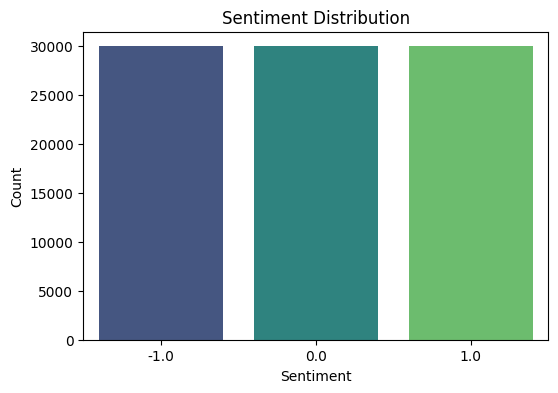

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

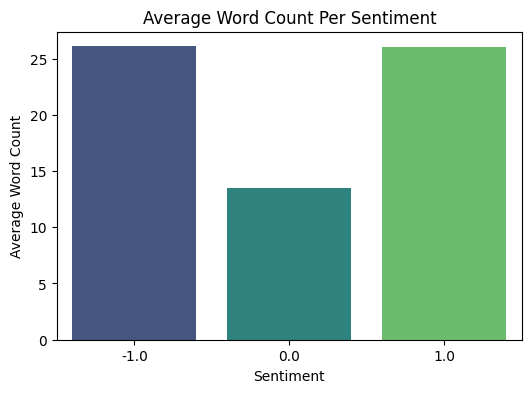

In [11]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
word_count = df.groupby('label')['word_count'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=word_count.index, y=word_count.values, palette='viridis')
plt.title('Average Word Count Per Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Count')
plt.show()

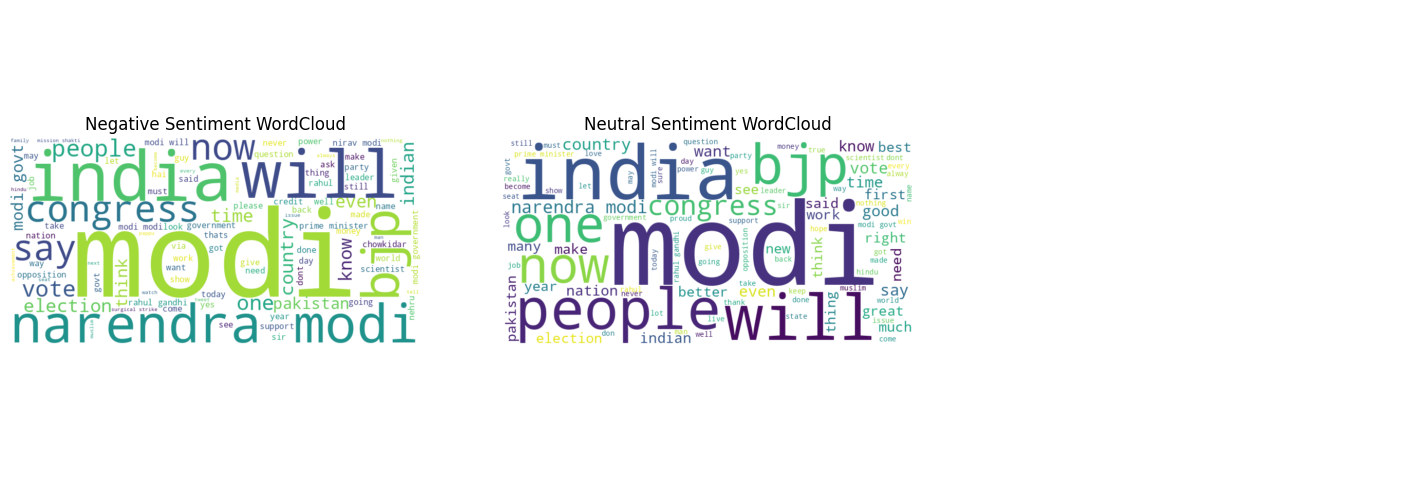

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
sentiments = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

for label, ax in zip(sentiments.keys(), axes):
    if label in df['label'].values:
        words = ' '.join(df[df['label'] == label]['text'])
        if words.strip():
            wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(words)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f'{sentiments[label]} Sentiment WordCloud')
    else:
        ax.axis('off')

plt.show()

In [13]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [21]:
label_mapping = {-1.0: 0, 0.0: 1, 1.0: 2}
train_labels = [label_mapping[label] for label in train_labels]
val_labels = [label_mapping[label] for label in val_labels]

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [23]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [24]:
def to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings), labels
    )).batch(16)

train_dataset = to_tf_dataset(train_encodings, train_labels)
val_dataset = to_tf_dataset(val_encodings, val_labels)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

Epoch 1/2
4500/4500 [==============================] - 2114s 462ms/step - loss: 0.2717 - accuracy: 0.9007 - val_loss: 0.1313 - val_accuracy: 0.9572
Epoch 2/2
4500/4500 [==============================] - 2072s 461ms/step - loss: 0.1002 - accuracy: 0.9685 - val_loss: 0.1208 - val_accuracy: 0.9608


In [28]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation Accuracy: {val_accuracy:.4f}')

1125/1125 [==============================] - 173s 154ms/step - loss: 0.1208 - accuracy: 0.9608
Validation Accuracy: 0.9608


In [29]:
model.save_pretrained('sentiment_model')
tokenizer.save_pretrained('sentiment_model')

('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/vocab.txt',
 'sentiment_model/added_tokens.json')

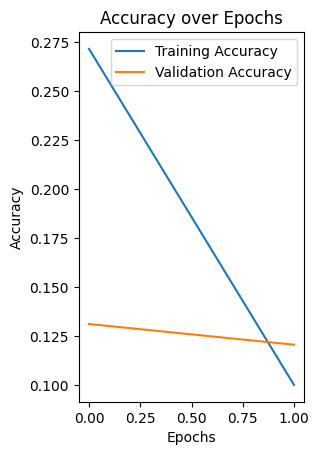

In [35]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

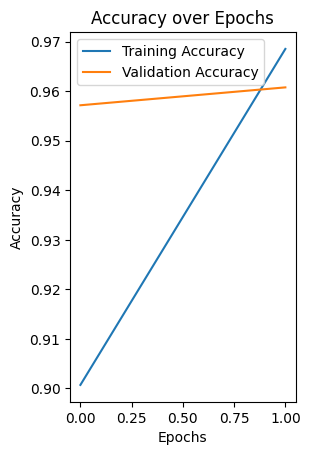

In [32]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [33]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = np.argmax(logits, axis=1).item()
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[predicted_class]


In [34]:
text = "I love eating pizzas!"
print(f'Sentiment: {predict_sentiment(text)}')

Sentiment: Positive
